Model 1 Test Data Analysis
==========================
Table of Contents
-----------------
1. [Data Loading](#Data-Loading)
2. [Latitudinal Analysis](#Latitudinal-Analysis)
3. [Longitudinal Analysis](#Longitudinal-Analysis)
4. [Time Series Analysis](#Time-Series-Analysis)
5. [Export Statistics](#Export-Statistics)

In [59]:
# Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [60]:
# Set the style of the visualization
sns.set_theme(style="darkgrid", palette="hls")
palette = sns.color_palette("hls", 8)

palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

In [61]:
# Set the model number for the model that was trained, and the number of models that were trained, and the model architecture file name
modelNum = 2
numModels = 6
modelArch = 'PrevailingWinds_6Split.csv'

# Data Loading

In [62]:
df = pd.read_csv(f'../Models/Model_{modelNum}/Model_{modelNum}_TestData.csv')
df.head()

,Lat,Lon,Alt,Precip (mm),Temp (°C),Year,JulianDaySin,O18 (‰) Actual,H2 (‰) Actual,O18 (‰) Predicted,H2 (‰) Predicted
0,68.300000,-133.483333,68.0,51.000000,10.700000,1988,-0.693281,-18.800000,-133.00000,-22.645796,-171.382740
1,37.770000,-25.650000,175.0,17.000000,18.600000,1988,0.280231,-1.180000,-6.30000,-2.615925,-10.825233
2,38.660389,-27.220094,74.0,54.000000,16.000000,1989,0.741222,-2.350000,-11.10000,-4.093438,-20.263958
3,72.580000,-38.479900,3200.0,0.875134,519.117163,2012,0.903356,-34.609999,-265.12089,-36.114742,-272.706050
4,64.130000,-21.930000,14.0,40.200000,10.500000,2005,0.296713,-7.620000,-60.41000,-8.280158,-56.601320


## Preparing the dataframe for analysis
Currently the dataframe looks good but in order to preform some analysis we will need to clean it up just a bit. We will start by converting the date to a datetime object and then by changing column names to not include units of measurement.

In [63]:
# Convert Year and Julian Sine Day to a single date
df['JulianDay'] = np.ceil((np.arcsin(df['JulianDaySin']) / np.pi + 0.5) * 365).astype(int)
df['Year'] = df['Year'].astype(int)

# Combine the Year and Julian Day into a single date
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '/' + df['JulianDay'].astype(str), format='%Y/%j')

In [64]:
# Remove the Year and Julian Day columns
df = df.drop(['Year', 'JulianDay', 'JulianDaySin'], axis=1)

In [65]:
# Cycle through the column names and change the names to be more usable in code
import re
oldColumns = df.columns
codeCols = list(map(lambda x: re.sub(r'\(.*?\)', '', x), oldColumns))

# Cycle through the column names and change ones that end in Actual or Predicted to be more usable in code (remove the word Actual or Predicted)
codeCols = list(map(lambda x: re.sub(r' Actual', 'A', x), codeCols))
codeCols = list(map(lambda x: re.sub(r' Predicted', 'P', x), codeCols))
codeCols = list(map(lambda x: x.strip(), codeCols))

# Create a dictionary to map the old column names to the new column names

# Rename the columns
df = df.rename(columns=dict(zip(oldColumns, codeCols)))

# Set the Date column as the index
df = df.set_index('Date')

# Sort the columns by date
df = df.sort_index()

df

,Lat,Lon,Alt,Precip,Temp,O18 A,H2 A,O18 P,H2 P
Date,,,,,,,,,
1960-05-30,37.900000,23.730000,27.0,131.00,14.200000,-7.200,-44.00,-6.259880,-36.801655
1960-12-03,51.930000,-10.250000,9.0,99.00,9.600000,-5.700,-39.70,-4.940252,-33.685623
1961-01-27,-4.620000,55.450000,1.0,279.00,26.800000,-3.300,-18.00,-4.170282,-22.029930
1961-01-27,64.130000,-21.930000,14.0,86.00,5.600000,-7.300,-51.40,-9.129982,-67.181860
1961-01-27,53.320000,-60.420000,46.0,130.00,3.300000,-14.000,-100.30,-14.826873,-103.823220
...,...,...,...,...,...,...,...,...,...
2022-12-06,14.640000,121.040000,42.0,150.00,28.300000,-3.290,-20.80,-4.485627,-26.557108
2022-12-28,44.051000,10.164000,160.0,67.12,11.700000,-5.930,-36.68,-3.387770,-17.833344
2023-07-12,47.816667,13.717778,1618.0,1.70,552.191534,-6.656,-48.90,-11.117622,-80.713554


In [66]:
# Group by latitude and longitude and calculate mean and standard deviation
dfStats = df.groupby(['Lat', 'Lon']).agg(
    {
        'O18 A': ['mean', 'std'],
        'O18 P': ['mean', 'std'],
        'H2 A': ['mean', 'std'],
        'H2 P': ['mean', 'std']
    }
).reset_index()

# Flatten the MultiIndex columns
dfStats.columns = ['_'.join(col).strip() for col in dfStats.columns.values]

# Rename the columns for clarity
dfStats.columns = [
    'Lat', 'Lon', 
    'O18 A_mean', 'O18 A_std', 
    'O18 P_mean', 'O18 P_std', 
    'H2 A_mean', 'H2 A_std', 
    'H2 P_mean', 'H2 P_std'
]

# Latitudinal Analysis
----------------------
Assessing the data by latitude

## O18 vs Latitude

Text(0, 0.5, 'O18‰')

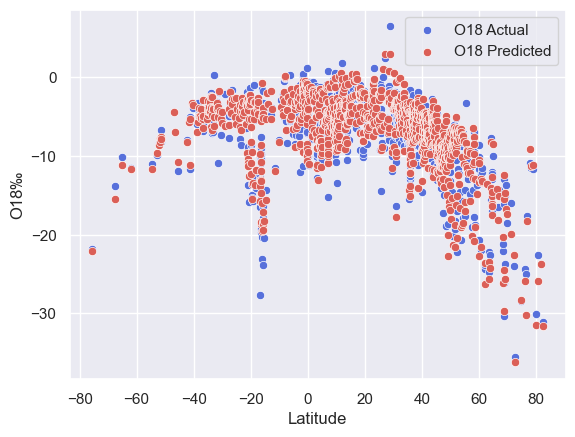

In [67]:
# Scatter plots of O18 Actual vs Predicted
plt.clf()
sns.scatterplot(data=dfStats, x='Lat', y='O18 A_mean', color=palette[5], label='O18 Actual')
sns.scatterplot(data=dfStats, x='Lat', y='O18 P_mean', color=palette[0], label='O18 Predicted') 

# Graph settings
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('O18\u2030')


## H2 vs Latitude

Text(0, 0.5, 'H2‰')

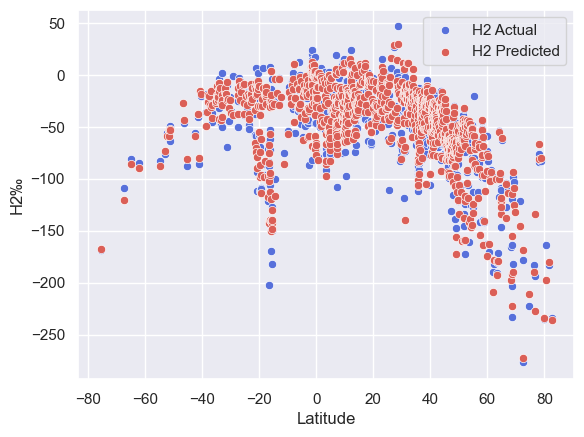

In [68]:
# Scatter plots of O18 Actual vs Predicted
plt.clf()
sns.scatterplot(data=dfStats, x='Lat', y='H2 A_mean', color=palette[5], label='H2 Actual')
sns.scatterplot(data=dfStats, x='Lat', y='H2 P_mean', color=palette[0], label='H2 Predicted') 

# Graph settings
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('H2\u2030')

# Longitudinal Analysis
-----------------------
Assessing the data by longitude to see how well the model is able to predict the data at different longitudes.

## O18 vs Longitude

Text(0, 0.5, 'O18‰')

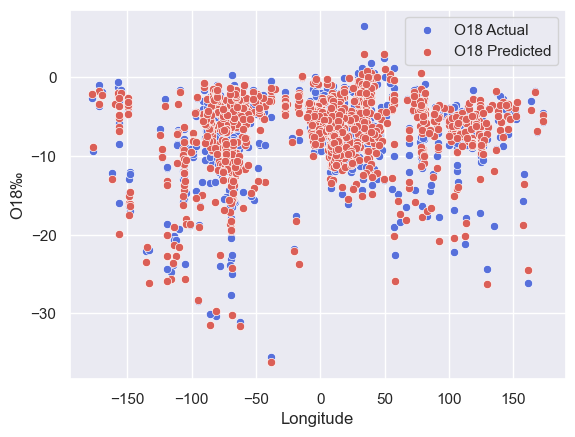

In [69]:
# Scatter plots of O18 Actual vs Predicted
plt.clf()
sns.scatterplot(data=dfStats, x='Lon', y='O18 A_mean', color=palette[5], label='O18 Actual')
sns.scatterplot(data=dfStats, x='Lon', y='O18 P_mean', color=palette[0], label='O18 Predicted')

# Graph settings
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('O18\u2030')

## H2 vs Longitude

Text(0, 0.5, 'H2‰')

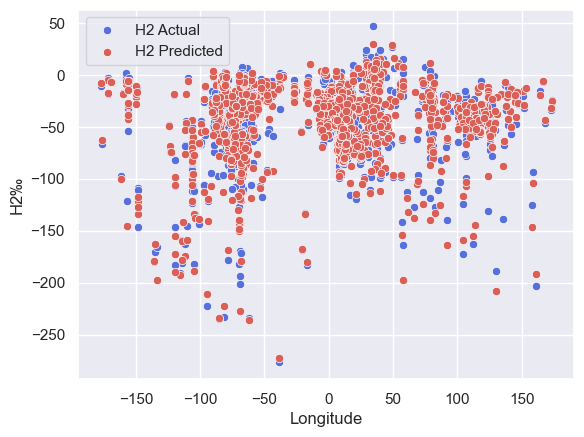

In [70]:
# Scatter plots of H2 Actual vs Predicted
plt.clf()
sns.scatterplot(data=dfStats, x='Lon', y='H2 A_mean', color=palette[5], label='H2 Actual')
sns.scatterplot(data=dfStats, x='Lon', y='H2 P_mean', color=palette[0], label='H2 Predicted')

# Graph settings
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('H2\u2030')

# Time Series Analysis

## Predicted vs Actual
We will start by just looking at the predicted vs actual values for the entire dataset on both isotopes.

Text(0, 0.5, 'O18‰ Predicted')

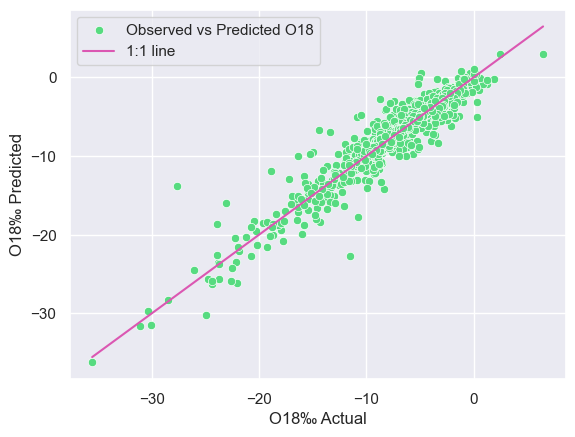

In [71]:
# Scatter plots of O18 Actual vs Predicted
plt.clf()
sns.scatterplot(data=dfStats, x='O18 A_mean', y='O18 P_mean', color=palette[3], label='Observed vs Predicted O18')
sns.lineplot(x=dfStats['O18 A_mean'], y=dfStats['O18 A_mean'], color=palette[7], label='1:1 line')

# Graph settings
plt.legend()
plt.xlabel('O18\u2030 Actual')
plt.ylabel('O18\u2030 Predicted')

Text(0, 0.5, 'H2‰ Predicted')

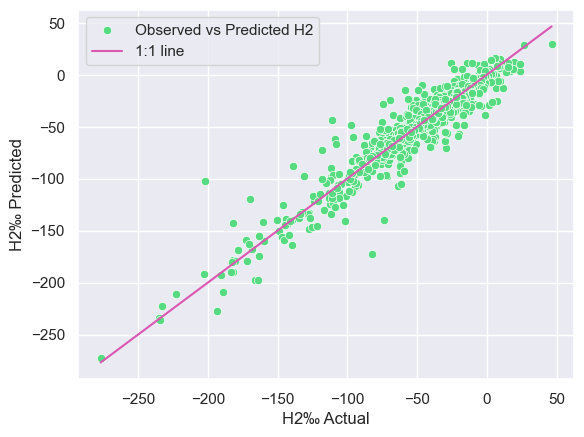

In [72]:
## Scatter plots of H2 Actual vs Predicted
plt.clf()
sns.scatterplot(data=dfStats, x='H2 A_mean', y='H2 P_mean', color=palette[3], label='Observed vs Predicted H2')
sns.lineplot(x=dfStats['H2 A_mean'], y=dfStats['H2 A_mean'], color=palette[7], label='1:1 line')

# Graph settings
plt.legend()
plt.xlabel('H2\u2030 Actual')
plt.ylabel('H2\u2030 Predicted')

## Date and Time Analysis
Starting by grouping the original data by latitude and longitude and then by date and time to see how the model is performing over time.

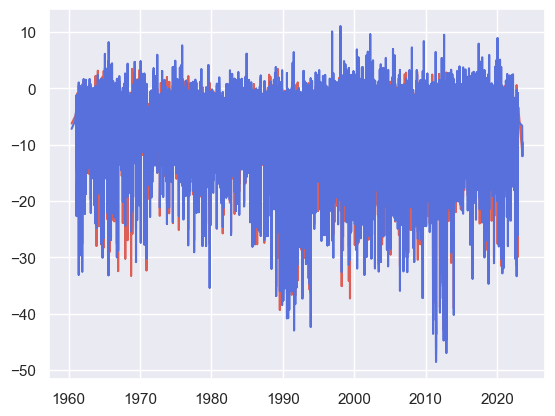

In [73]:
# Plot the O18 Actual and Predicted values 
plt.plot(df['O18 P'], color=palette[0], label='Predicted')
plt.plot(df['O18 A'], color=palette[5], label='Actual')

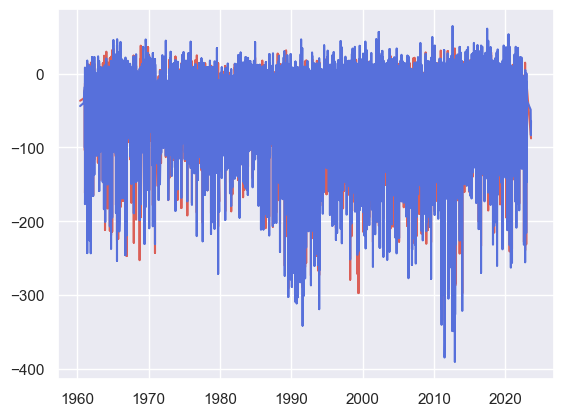

In [74]:
# Plot the H2 Actual and Predicted values
plt.plot(df['H2 P'], color=palette[0], label='Predicted')
plt.plot(df['H2 A'], color=palette[5], label='Actual')

# Export Statistics
We will export the statistics for the model to a csv file for further analysis.

In [75]:
# Create a function that takes in a predicted and actual values and returns the KGE assuming pandas dataframes
def calculate_kge(actual, predicted):
    # Calculate the mean of the actual and predicted values
    meanActual = actual.mean()
    meanPredicted = predicted.mean()
    beta = meanPredicted / meanActual

    # Calculate the standard deviation of the actual and predicted values
    stdActual = actual.std()
    stdPredicted = predicted.std()
    alpha = stdPredicted / stdActual

    # Calculate the correlation between the actual and predicted values
    correlation = predicted.corr(actual)

    # Calculate the Kling-Gupta Efficiency
    kge = 1 - np.sqrt((alpha - 1) ** 2 + (beta - 1) ** 2 + (correlation - 1) ** 2)
    
    return kge

In [76]:
# Create a function that takes in a predicted and actual values and returns the RMSE assuming pandas dataframes
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [77]:
# Create a new stats dataframe to store the KGE and RMSE values for all isotopes across all models (lat, lon)
stats = pd.DataFrame(columns=['O18 KGE', 'H2 KGE', 'O18 RMSE', 'H2 RMSE'])

stats['O18 KGE'] = df.groupby(['Lat', 'Lon']).apply(lambda x: calculate_kge(x['O18 A'], x['O18 P']))
stats['H2 KGE'] = df.groupby(['Lat', 'Lon']).apply(lambda x: calculate_kge(x['H2 A'], x['H2 P']))
stats['O18 RMSE'] = df.groupby(['Lat', 'Lon']).apply(lambda x: calculate_rmse(x['O18 A'], x['O18 P']))
stats['H2 RMSE'] = df.groupby(['Lat', 'Lon']).apply(lambda x: calculate_rmse(x['H2 A'], x['H2 P']))

stats

In [34]:
# Create a function that will only be used if there are multiple models it will find the correct model 
# This function will take in a dataframe and modelName (and geometry) and return the KGE and RMSE values
# within the architecture of the modelName
def modelStats_loc(df, modelName, modelArch):
    # Load the model architecture
    arch = pd.read_csv(f'../Data/ModelSplit_Arch/{modelArch}')
    # Convert the arch to a geodataframe
    arch = gpd.GeoDataFrame(arch, geometry=gpd.GeoSeries.from_wkt(arch['Geometry']), crs='EPSG:4326')
    arch.set_index('Prevailing Wind', inplace=True)
    arch.drop(columns=['Geometry'], inplace=True)

    # Convert the df to a geodataframe
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat), crs='EPSG:4326')
    
    df = df[df.within(arch.geometry.loc[modelName])] # Filter the dataframe to only include the points within the model geometry

    # Convert the df back to a dataframe
    return pd.DataFrame(df).drop(columns=['geometry'])

In [36]:
# Finally I will export the stats dataframe to a csv file or and excel file with each sheet being a different model 
# if there are multiple models that were trained
if numModels > 1:
    # Load the model architecture
    arch = pd.read_csv(f'../Data/ModelSplit_Arch/{modelArch}')
    # Convert the arch to a geodataframe
    arch = gpd.GeoDataFrame(arch, geometry=gpd.GeoSeries.from_wkt(arch['Geometry']), crs='EPSG:4326')
    arch.set_index('Prevailing Wind', inplace=True)
    arch.drop(columns=['Geometry'], inplace=True)
    with pd.ExcelWriter(f'Model_{modelNum}_Stats.xlsx') as writer:
        for modelName in list(arch.index):
            modelstats = modelStats_loc(stats.reset_index(), modelName, modelArch)
            modelstats.to_excel(writer, sheet_name=modelName, index=False)
else:
    stats.to_csv(f'Model_{modelNum}_Stats.csv', index=False)